In [254]:
from datetime import datetime
from datetime import timezone
import polars as pl
import os
from plot_data import plot_sensor_measurement, plot_sensor_calibration, plot_wind_rose


start_date = datetime(2023, 8, 1, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 10, 14, 23, 59, 59).replace(tzinfo=timezone.utc)

sensor_id = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20]
data_directory = "../data/"


In [255]:
# parquet created by notebook: perform_pivot_on_db.ipynb
df_new = pl.scan_parquet(os.path.join(data_directory, "pivot_measurements.parquet"))
# parquet created by notebook: Old Database/convert_old_parquet.ipynb
df_old = pl.scan_parquet(os.path.join(data_directory, "old_db_renamed_measurements.parquet"))
# parquet created by notebook: process_calibration_data.ipynb
df_cal = pl.scan_parquet(os.path.join(data_directory, "calibration_correction.parquet"))

columns = ["creation_timestamp","system_name", "gmp343_filtered"]
# TODO: add all relevant columns

df_new = df_new.select(columns) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))
df_old = df_old.select(columns) \
.with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us"))

df = pl.concat([df_new, df_old]).sort("creation_timestamp")

df = df.sort("creation_timestamp").filter(pl.col("creation_timestamp").is_between(start_date, end_date))

# Broadcast for 1 system (working)

In [264]:
def broadcast_cal_cor_backward(system):
    t1 = df.filter(pl.col("system_name") == system) \
        .with_columns(pl.col("creation_timestamp").dt.date() \
        .alias("date"))

    t2 = df_cal.filter(pl.col("system_name") == system) \
        .select(["creation_timestamp", "system_name","slope","intercept"]) \
        .rename({"creation_timestamp": "date"})
        
    t1 = t1.join(t2, on = "date", how= "left") \
        .with_columns(pl.col("slope")) \
        .fill_null(strategy = "backward") \
        .fill_null(strategy = "forward") \
        .select(["creation_timestamp","system_name", "slope", "intercept"])
    
    t3 = df.sort("creation_timestamp") \
    .join(t1, on=["system_name","creation_timestamp"], how= "left") \
    .filter(pl.col("gmp343_filtered") > 0) \
    .with_columns((pl.col("gmp343_filtered") * pl.col("slope") + pl.col("intercept")) \
    .alias("gmp343_corrected")).collect() \
    .select(["creation_timestamp","system_name","gmp343_filtered","gmp343_corrected","slope","intercept"])

    return t3
    
t3 = broadcast_cal_cor_backward("tum-esm-midcost-raspi-1")
   
import plotly.express as px

df_corr = t3.groupby_dynamic("creation_timestamp", every='1h').agg(
                pl.all().exclude("creation_timestamp").mean())

fig = px.line(df_corr, x="creation_timestamp", y="slope", markers=True, title = "slope", color="system_name")
fig.show()

fig = px.line(df_corr, x="creation_timestamp", y="gmp343_corrected", markers=True, title = "gmp343_corrected", color="system_name")
fig.show()

# Broadcast for multiple systems (semi working)

In [271]:
sensor_id = [1,2,4]

def broadcast_cal_corr(system):
    t1 = df.filter(pl.col("system_name") == system) \
        .with_columns(pl.col("creation_timestamp").dt.date() \
        .alias("date"))

    t2 = df_cal.filter(pl.col("system_name") == system) \
        .select(["creation_timestamp", "system_name","slope","intercept"]) \
        .rename({"creation_timestamp": "date"})
        
    t1 = t1.join(t2, on = "date", how= "left") \
        .with_columns(pl.col("slope")) \
        .fill_null(strategy = "backward") \
        .fill_null(strategy = "forward") \
        .select(["creation_timestamp","system_name", "slope", "intercept"])
    
    t3 = df.sort("creation_timestamp") \
    .join(t1, on=["system_name","creation_timestamp"], how= "left") \
    .filter(pl.col("gmp343_filtered") > 0) \
    .with_columns((pl.col("gmp343_filtered") * pl.col("slope") + pl.col("intercept")) \
    .alias("gmp343_corrected")) \
    .collect() \
    .select(["creation_timestamp","system_name","gmp343_filtered","gmp343_corrected","slope","intercept"])

    return t3

l_df_corr =[]

for id in sensor_id:
    df_corr = broadcast_cal_corr(f"tum-esm-midcost-raspi-{id}")
    l_df_corr.append(df.join(df_corr.lazy(), on=["creation_timestamp", "system_name"]).collect())


In [ ]:
# TODO: now join all in l_df_corr

In [272]:
import plotly.express as px

df_corr_agg = l_df_corr[1].groupby_dynamic("creation_timestamp", every='1h').agg(pl.all().exclude("creation_timestamp").mean())

fig = px.line(df_corr_agg, x="creation_timestamp", y="slope", markers=True, title = "slope", color="system_name")
fig.show()

fig = px.line(df_corr_agg, x="creation_timestamp", y="intercept", markers=True, title = "intercept", color="system_name")
fig.show()

fig = px.line(df_corr_agg, x="creation_timestamp", y="gmp343_corrected", markers=True, title = "gmp343_corrected", color="system_name")
fig.show()

In [45]:
# t1 = df.with_columns(pl.col("creation_timestamp").dt.date().alias("date"))

# t2 = df_cal.select(["creation_timestamp", "system_name","slope", "intercept"]).rename({"creation_timestamp": "date"})

# t1 = t1.join(t2, on = ["date","system_name"], how= "left") \
#     .with_columns(pl.col("slope")).fill_null(strategy = "backward") \
#     .select(["creation_timestamp","system_name", "slope", "intercept"]).sort("creation_timestamp")

# df_corr = df.join(t1, on=["system_name","creation_timestamp"], how= "left") \
#     .filter(pl.col("gmp343_filtered") > 0) \
#     .with_columns((pl.col("gmp343_filtered") * pl.col("slope") + pl.col("intercept")) \
#     .alias("gmp343_corrected")) \
#     .collect() \
#     .select(["creation_timestamp","system_name","gmp343_filtered","gmp343_corrected","slope"]) \
#     .sort("creation_timestamp")

# import plotly.express as px

# df_corr_2 = df_corr.filter(pl.col("system_name")=="tum-esm-midcost-raspi-6").groupby_dynamic("creation_timestamp", every='1h').agg(
#                 pl.all().exclude("creation_timestamp").mean())

# fig = px.line(df_corr_2, x="creation_timestamp", y="slope", markers=True, title = "slope", color="system_name")
# fig.show()
    

In [ ]:
plot_sensor_measurement(df_corr,col_name="slope",sensor_id=[6,7,8,10,11,12,13,16,18],filter='1h')

In [ ]:
plot_sensor_measurement(df_corr,col_name="gmp343_corrected",sensor_id=[6,7,8,10,11,12,13,16,18],filter='1h')

# Slow correction (faster through initial agg per hour)

In [273]:
dfg = df.groupby_dynamic("creation_timestamp", every="1h", by="system_name").agg(pl.col("gmp343_filtered").mean())

dfg.tail(3).collect()

system_name,creation_timestamp,gmp343_filtered
str,"datetime[μs, UTC]",f64
"""tum-esm-midcos…",2023-10-14 22:00:00 UTC,417.331111
"""tum-esm-midcos…",2023-10-14 23:00:00 UTC,412.770195
"""tum-esm-midcos…",2023-08-07 16:00:00 UTC,413.345161


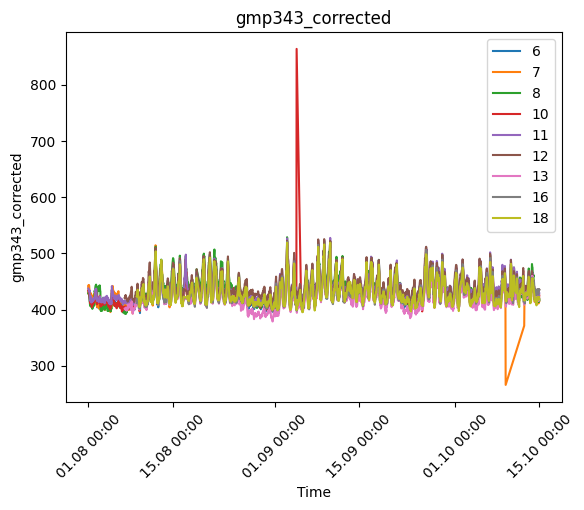

In [274]:
def calibration_correction(date,name,item):
    try:
        intercept = df_cal.filter(pl.col('system_name') == name) \
            .filter(pl.col('creation_timestamp') < date).last() \
            .select("intercept").collect().item()
        slope = df_cal.filter(pl.col('system_name') == name) \
            .filter(pl.col('creation_timestamp') < date).last() \
            .select("slope").collect().item()
        
        return item * slope + intercept
    except:
        return None


df_m = dfg.filter(pl.col("gmp343_filtered") > 0) \
        .with_columns(pl.struct(['creation_timestamp','system_name','gmp343_filtered']) \
        .apply(lambda x: calibration_correction(x['creation_timestamp'],x['system_name'],x['gmp343_filtered'])) \
        .alias('gmp343_corrected'))

plot_sensor_measurement(df_m.collect(),col_name="gmp343_corrected",sensor_id=[6,7,8,10,11,12,13,16,18],filter='1h')

# Plot other data directly from database parquet

In [ ]:
df = df.collect()

In [ ]:
plot_sensor_measurement(df,col_name="gmp343_raw",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="gmp343_compensated",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="gmp343_filtered",sensor_id=[1,2,3,4,6],filter='1h')
plot_sensor_measurement(df,col_name="gmp343_filtered",sensor_id=sensor_id,filter='1h')

In [ ]:
# Maisach
plot_wind_rose(df,1, 'Maisach')
# Rechts-der-Isar
plot_wind_rose(df,2, 'Rechts-der-Isar')
# Finsing
plot_wind_rose(df,3, 'Finsing')
# Großhadern
plot_wind_rose(df,4, 'Großhadern')
# Großhadern
plot_wind_rose(df,5, 'Pasing')
# plot wind at 3m pole inlet
plot_wind_rose(df,7, 'TUM')

In [ ]:
plot_sensor_measurement(df,col_name="wxt532_speed_avg",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="wxt532_direction_avg",sensor_id=sensor_id,filter='1h')

In [ ]:
# Plot auxilliary data
plot_sensor_measurement(df,col_name="sht45_humidity",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="bme280_humidity",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="sht45_temperature",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="bme280_temperature",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="bme280_pressure",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="gmp343_temperature",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="raspi_cpu_usage",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="raspi_disk_usage",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="raspi_memory_usage",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="raspi_cpu_temperature",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="enclosure_bme280_humidity",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="enclosure_bme280_pressure",sensor_id=sensor_id,filter='1h')

In [ ]:
plot_sensor_measurement(df,col_name="enclosure_bme280_temperature",sensor_id=sensor_id,filter='1h')

In [ ]:
# Plot Calibration Data 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None)

In [ ]:
# Plot 400ppm Calibration Bottle 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None, cut_above= 450, cut_below=350)


In [ ]:
# Plot 800ppm Calibration Bottle 
plot_sensor_calibration(df, col_name = "cal_gmp343_filtered", sensor_id=sensor_id, filter = None, cut_below=700)